<h1>Model training

In [ ]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
import os
import pandas as pd
from torch.nn import HuberLoss, MSELoss, L1Loss

# # Lists to store models and scalers
# models = {}
# scalers = {}
# encoders = {}
# input_sizes = {}
# losses = {}

# Load all parameters
models = joblib.load("parameters/models.pth")
scalers = joblib.load("parameters/scalers.pkl")
encoders = joblib.load("parameters/encoders.pkl")
input_sizes = joblib.load("parameters/input_sizes.pkl")
losses = joblib.load("parameters/losses.pkl")

# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# PyTorch Dataset Class
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

input_dir = r"..\data\WPPs+production+reforecast"

for file in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file)
    if os.path.isfile(file_path):  # Ensure it's a file (not a folder)
        lead_time = int(file.split("_")[-1].replace(".json", ""))
        with open(file_path, "r", encoding="utf-8") as file:
            forecast_data = json.load(file)

    print(f"Processing lead time: {lead_time}")

    print(f"    Data preparation")

    all_turbine_types = []
    all_hub_heights = []
    all_capacities = []
    all_commissioning_dates = []
    all_production_data = []

    for unique_key, wpp in forecast_data.items():
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Time Series"])

    # One-Hot-Encoding for turbine types
    encoder = OneHotEncoder(sparse_output=False)
    turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

    # convert to datetime
    standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

    # calculate age
    ref_date = pd.Timestamp("2024-12-01")
    ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

    # create combined features and output lists
    combined_features_raw = []
    output_raw = []
    
    # convert data in feature arrays
    for idx, production_data in enumerate(all_production_data):
        num_rows = len(production_data)

        # Repetitions for common features
        turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
        hub_height_repeated = np.full((num_rows, 1), float(all_hub_heights[idx]))
        age_repeated = np.full((num_rows, 1), ages[idx])

        # Extract production values and wind speeds
        production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
        wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

        # combine all features
        combined_chunk = np.hstack((
            turbine_type_repeated,
            hub_height_repeated,
            age_repeated,
            wind_speeds
        ))

        # add the data
        combined_features_raw.append(combined_chunk)
        output_raw.append(production_values)

    # combine all data chunks to one array
    combined_features = np.vstack(combined_features_raw)
    output = np.vstack(output_raw)

    # Interpolate missing values (linear interpolation) in pandas
    wind_speed_series = pd.Series(combined_features[:, -1])
    wind_speed_series.interpolate(method='linear', inplace=True)
    combined_features[:, -1] = wind_speed_series.to_numpy()

    # round all values to two decimal places
    combined_features = np.round(combined_features, decimals=4)
    output = np.round(output, decimals=4)
        
    # Normalise numerical features
    scaler_wind = StandardScaler()
    scaler_ages = StandardScaler()
    scaler_hub_heights = StandardScaler()

    # Skalieren der einzelnen Features
    combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
    combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
    combined_features[:, -3] = scaler_hub_heights.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale hub heights
    
    # Convert to PyTorch Dataset
    dataset = WindPowerDataset(combined_features, output)
    
    params = {"batch_size": 128,
          "lr": 0.00010155,
          "number_epochs": 10}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train-test split
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # shuffling doesn't matter here, has already taken place during train_test_split
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)
    
    # Model setup
    input_size = combined_features.shape[1]

    # use static instead of dynamic computational graphs
    model = torch.jit.script(MLP(input_size=input_size)).to(device)
    model.to(device)
    
    # Trainings-Konfiguration
    mae_criterion = L1Loss()
    mse_criterion = MSELoss()
    huber_criterion = HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # Training
    print(f"    Training")
    for epoch in range(params["number_epochs"]):
        print(f"        Epoch {epoch + 1}/{params['number_epochs']}")
        model.train()
        train_loss_mae, train_loss_mse, train_loss_huber = 0, 0, 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            
            # Calculate losses for each criterion
            loss_mae = mae_criterion(outputs, batch_y)
            loss_mse = mse_criterion(outputs, batch_y)
            loss_huber = huber_criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss_huber.backward()
            optimizer.step()

            # Accumulate losses for logging
            train_loss_mae += loss_mae.item()
            train_loss_mse += loss_mse.item()
            train_loss_huber += loss_huber.item()

        train_loss_mae /= len(train_loader)
        train_loss_mse /= len(train_loader)
        train_loss_huber /= len(train_loader)

    # Testen
    print(f"    Testing")
    model.eval()

    test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)
            
            test_loss_mae += mae_criterion(preds, batch_y).item()
            test_loss_mse += mse_criterion(preds, batch_y).item()
            test_loss_huber += huber_criterion(preds, batch_y).item()

    test_loss_mae /= len(test_loader)
    test_loss_mse /= len(test_loader)
    test_loss_huber /= len(test_loader)
    
    models[lead_time] = model.state_dict()
    
    scalers[lead_time] = {
        "wind_scaler": scaler_wind,
        "scaler_ages": scaler_ages,
        "scaler_hub_heights": scaler_hub_heights
    }

    encoders[lead_time] = encoder

    input_sizes[lead_time] = input_size

    losses[lead_time] = {
        "Training": {
            "Huber": train_loss_huber,
            "MAE": train_loss_mae,
            "MSE":train_loss_mse
        },
        "Testing": {
            "Huber": test_loss_huber,
            "MAE": test_loss_mae,
            "MSE": test_loss_mse
        },
    }

# Save all parameters
joblib.dump(models, "parameters/models.pth")
joblib.dump(scalers, "parameters/scalers.pkl")
joblib.dump(encoders, "parameters/encoders.pkl")
joblib.dump(input_sizes, "parameters/input_sizes.pkl")
joblib.dump(losses, "parameters/losses.pkl")
print("All parameters saved successfully.")

Processing lead time: 102
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 105
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 108
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 111
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10

<h1>Plotting results

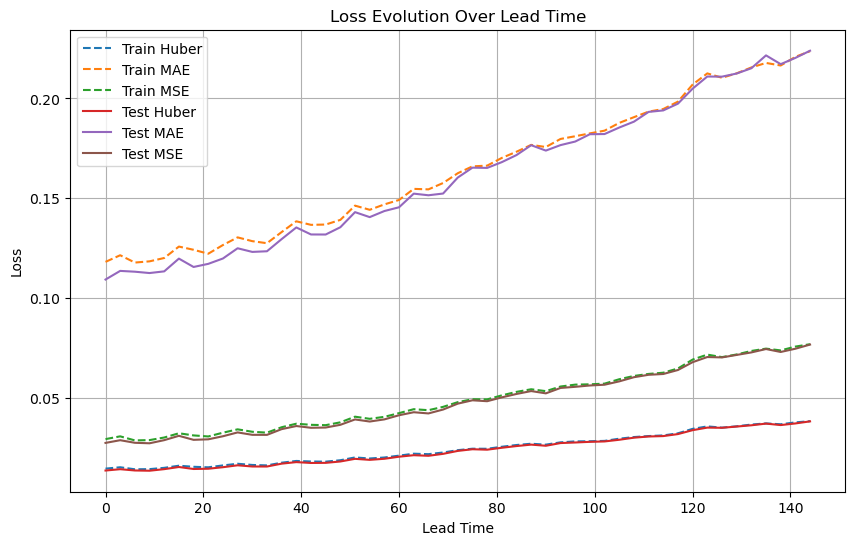

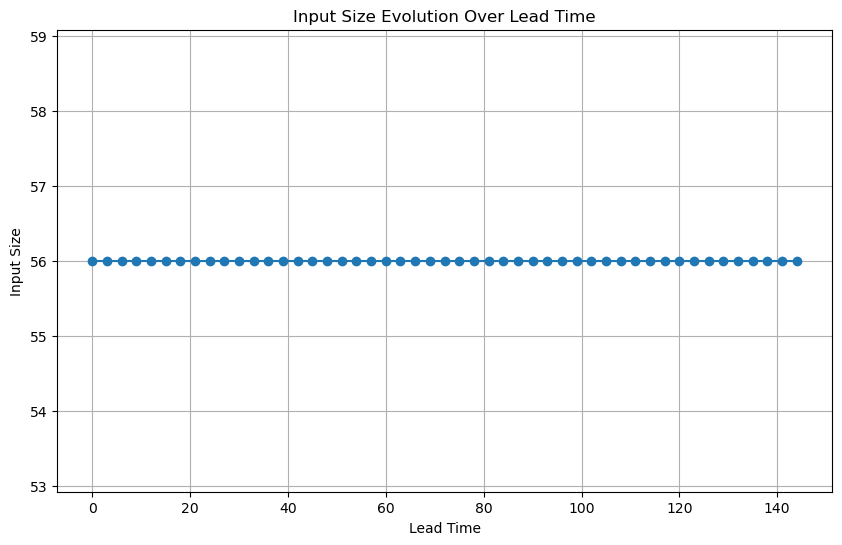

In [47]:
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load all parameters
models = joblib.load("parameters/models.pth")
scalers = joblib.load("parameters/scalers.pkl")
encoders = joblib.load("parameters/encoders.pkl")
input_sizes = joblib.load("parameters/input_sizes.pkl")
losses = joblib.load("parameters/losses.pkl")

# Convert lead times to sorted list
lead_times = sorted(models.keys())

# Extract losses for plotting
train_huber_losses = [losses[lt]["Training"]["Huber"] for lt in lead_times]
train_mae_losses = [losses[lt]["Training"]["MAE"] for lt in lead_times]
train_mse_losses = [losses[lt]["Training"]["MSE"] for lt in lead_times]

test_huber_losses = [losses[lt]["Testing"]["Huber"] for lt in lead_times]
test_mae_losses = [losses[lt]["Testing"]["MAE"] for lt in lead_times]
test_mse_losses = [losses[lt]["Testing"]["MSE"] for lt in lead_times]

# Plot losses over lead time
plt.figure(figsize=(10, 6))
plt.plot(lead_times, train_huber_losses, label="Train Huber", linestyle="dashed")
plt.plot(lead_times, train_mae_losses, label="Train MAE", linestyle="dashed")
plt.plot(lead_times, train_mse_losses, label="Train MSE", linestyle="dashed")
plt.plot(lead_times, test_huber_losses, label="Test Huber", linestyle="solid")
plt.plot(lead_times, test_mae_losses, label="Test MAE", linestyle="solid")
plt.plot(lead_times, test_mse_losses, label="Test MSE", linestyle="solid")
plt.xlabel("Lead Time")
plt.ylabel("Loss")
plt.title("Loss Evolution Over Lead Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot input_sizes over lead time
input_sizes_values = [input_sizes[lt] for lt in lead_times]

plt.figure(figsize=(10, 6))
plt.plot(lead_times, input_sizes_values, marker="o", linestyle="solid")
plt.xlabel("Lead Time")
plt.ylabel("Input Size")
plt.title("Input Size Evolution Over Lead Time")
plt.grid(True)
plt.show()

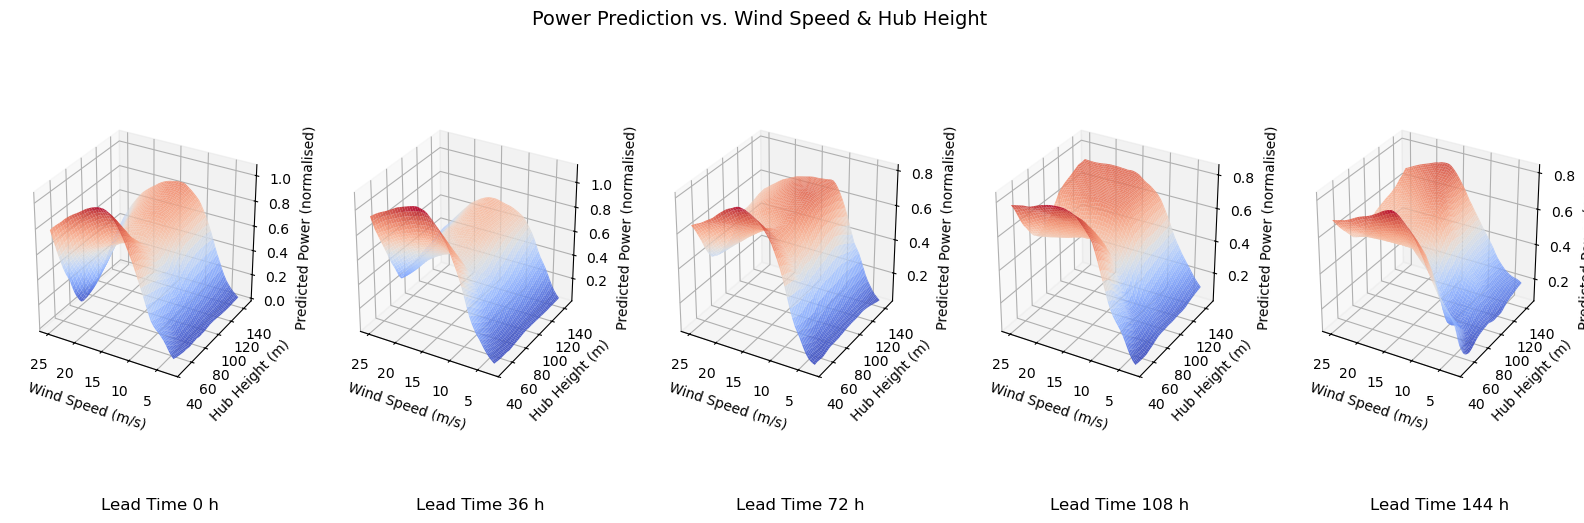

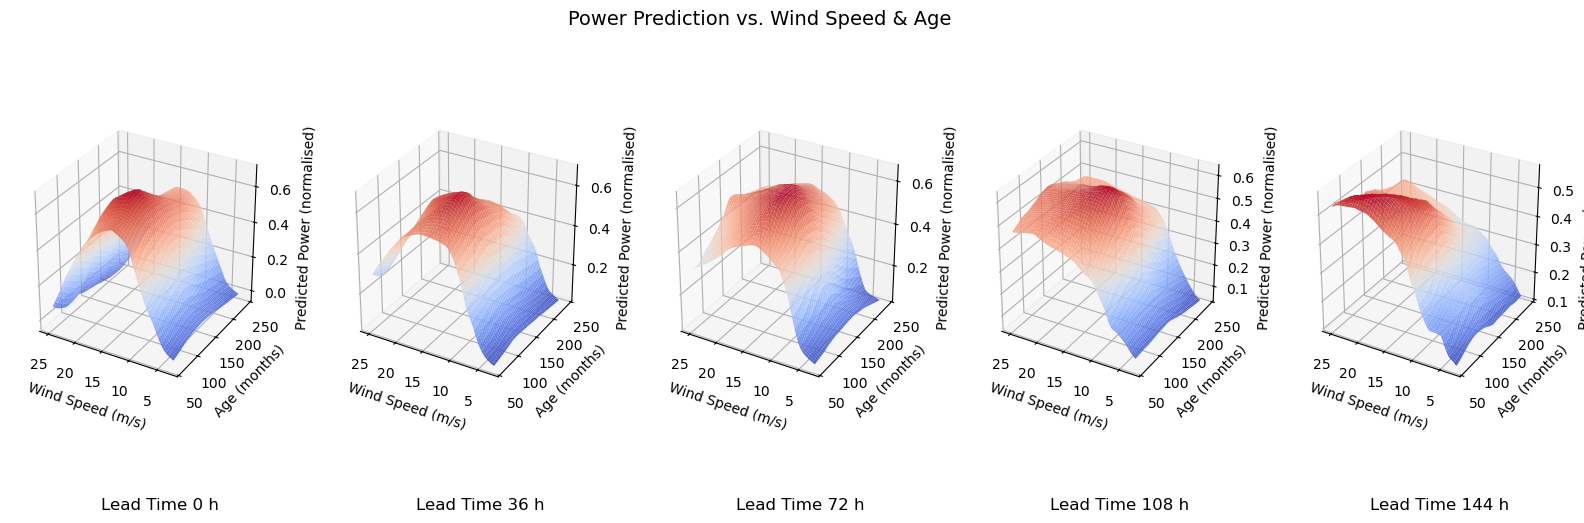

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def generate_3D_plot(ax, model, scaler_wind, scaler_hub, scaler_age, lead_time, feature_range, feature_name, wind_speed_range=(3, 25), hub_height=90, age=100):
    """
    Generates a 3D plot for power predictions based on either Wind Speed & Hub Height or Wind Speed & Age.
    """
    wind_speeds = np.linspace(*wind_speed_range, 50)  # Wind speeds from 3 to 25 m/s
    wind_speeds_grid, feature_grid = np.meshgrid(wind_speeds, feature_range)

    wind_speeds_flat = wind_speeds_grid.flatten()  # Shape: (5000,)
    feature_flat = feature_grid.flatten()  # Shape: (5000,)

    # Scale wind speeds
    wind_speeds_scaled = scaler_wind.transform(wind_speeds_flat.reshape(-1, 1)).flatten()

    num_samples = len(wind_speeds_scaled)  # Ensure all arrays have the same shape

    # Get number of turbine types and distribute uniformly
    num_turbine_types = len(encoders[lead_time].categories_[0])  
    avg_turbine_type = np.full((num_samples, num_turbine_types), 1/num_turbine_types)

    if feature_name == "hub_height":
        hub_heights_scaled = scaler_hub.transform(feature_flat.reshape(-1, 1)).flatten()
        ages_scaled = scaler_age.transform(np.full((num_samples, 1), age)).flatten()
    elif feature_name == "age":
        hub_heights_scaled = scaler_hub.transform(np.full((num_samples, 1), hub_height)).flatten()
        ages_scaled = scaler_age.transform(feature_flat.reshape(-1, 1)).flatten()

    # Ensure all arrays are correctly reshaped
    wind_speeds_scaled = wind_speeds_scaled.reshape(-1, 1)
    hub_heights_scaled = hub_heights_scaled.reshape(-1, 1)
    ages_scaled = ages_scaled.reshape(-1, 1)

    # Construct feature matrix
    all_features = np.hstack([
        avg_turbine_type,  
        hub_heights_scaled,
        ages_scaled,
        wind_speeds_scaled
    ])

    # Make predictions
    input_tensor = torch.tensor(all_features, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(input_tensor).numpy().flatten()

    # Reshape predictions to match the grid
    predictions_grid = predictions.reshape(wind_speeds_grid.shape)

    # Plot the surface
    surf = ax.plot_surface(wind_speeds_grid, feature_grid, predictions_grid, cmap='coolwarm', edgecolor='none', alpha=0.9)

    ax.set_xlim(ax.get_xlim()[::-1])  # Flip the x-axis
    ax.set_xlabel("Wind Speed (m/s)")
    ax.set_ylabel("Hub Height (m)" if feature_name == "hub_height" else "Age (months)")
    ax.set_zlabel("Predicted Power (normalised)")
    ax.set_box_aspect([1, 1, 1])



# Define Lead Times
selected_lead_times = [0, 36, 72, 108, 144]

# 1st Row: Wind Speed vs. Hub Height
fig1, axes1 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})
fig1.suptitle("Power Prediction vs. Wind Speed & Hub Height", fontsize=14)

for i, lt in enumerate(selected_lead_times):
    model = MLP(input_sizes[lt])  # Create an instance of MLP with correct input size
    model.load_state_dict(models[lt])  # Load the stored weights
    model.eval()  # Set to evaluation mode
    generate_3D_plot(axes1[i], model, scalers[lt]["wind_scaler"], scalers[lt]["scaler_hub_heights"], scalers[lt]["scaler_ages"],
                     lt, np.linspace(47, 145, 100), feature_name="hub_height", age=100)

# Add Age Labels Below the Subplots
for i, lt in enumerate(selected_lead_times):
    fig1.text(0.2 + i * 0.16, -0.02, f"Lead Time {lt} h", ha="center", fontsize=12, transform=fig1.transFigure)

plt.show()

# 2nd Row: Wind Speed vs. Age
fig2, axes2 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})
fig2.suptitle("Power Prediction vs. Wind Speed & Age", fontsize=14)

for i, lt in enumerate(selected_lead_times):
    model = MLP(input_sizes[lt])  # Create an instance of MLP with correct input size
    model.load_state_dict(models[lt])  # Load the stored weights
    model.eval()  # Set to evaluation mode
    generate_3D_plot(axes2[i], model, scalers[lt]["wind_scaler"], scalers[lt]["scaler_hub_heights"], scalers[lt]["scaler_ages"],
                     lt, np.linspace(60, 240, 100), feature_name="age", hub_height=90)
    
# Add Age Labels Below the Subplots
for i, lt in enumerate(selected_lead_times):
    fig2.text(0.2 + i * 0.16, -0.02, f"Lead Time {lt} h", ha="center", fontsize=12, transform=fig2.transFigure)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

df = pd.read_parquet("data/WPPs/The_Wind_Power.parquet")
hub_height_min = min(df["Hub height"].values)
hub_height_max = max(df["Hub height"].values)
age_min = min(df["Ages months"].values)
age_max = max(df["Ages months"].values)

def generate_plot(feature_range, feature_name, ax, wind_speed_range=(0, 30), hub_height=90, age=100):
    wind_speeds = np.linspace(*wind_speed_range, 500)  # Wind speeds from 0 to 30 m/s

    # Create meshgrid for wind speeds and the feature range (hub height or age)
    wind_speeds_grid, feature_grid = np.meshgrid(wind_speeds, feature_range)
    wind_speeds_flat = wind_speeds_grid.flatten()
    feature_flat = feature_grid.flatten()

    # Scale features
    wind_speeds = scalers["winds"].transform(wind_speeds_flat.reshape(-1, 1)).flatten()
    avg_turbine_type = np.zeros((len(wind_speeds), len(known_turbine_types))) / len(known_turbine_types)

    if feature_name == "hub_height":
        hub_heights = scalers["hub_heights"].transform(feature_flat.reshape(-1, 1)).flatten()
        ages = scalers["ages"].transform(np.full((len(wind_speeds), 1), age)).flatten()
    elif feature_name == "age":
        hub_heights = scalers["hub_heights"].transform(np.full((len(wind_speeds), 1), hub_height)).flatten()
        ages = scalers["ages"].transform(feature_flat.reshape(-1, 1)).flatten()

    # Construct feature matrix
    all_features = np.hstack([
        avg_turbine_type,
        hub_heights.reshape(-1, 1),
        ages.reshape(-1, 1),
        wind_speeds.reshape(-1, 1)
    ])

    # Make predictions
    input_tensor = torch.tensor(all_features, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(input_tensor).numpy().flatten()

    # Reshape predictions to match the grid
    predictions_grid = predictions.reshape(wind_speeds_grid.shape)

    # Plot the surface
    surf = ax.plot_surface(wind_speeds_grid, feature_grid, predictions_grid, cmap='coolwarm', edgecolor='none', alpha=0.9)

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("Wind Speed (m/s)")
    ax.set_ylabel("Hub Height (m)" if feature_name == "hub_height" else "Age (months)")
    ax.set_zlabel("Predicted Power (normalised)")
    ax.set_box_aspect([1, 1, 1])
    


# **1. Image: Trained value range**
fig1, axes1 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig1.suptitle("Hub Height from 47 to 145 m", fontsize=14)

generate_plot(np.linspace(47, 145, 100), feature_name="hub_height", ax=axes1[0], age=7)
generate_plot(np.linspace(47, 145, 100), feature_name="hub_height", ax=axes1[1], age=71.25)
generate_plot(np.linspace(47, 145, 100), feature_name="hub_height", ax=axes1[2], age=135.5)
generate_plot(np.linspace(47, 145, 100), feature_name="hub_height", ax=axes1[3], age=199.75)
generate_plot(np.linspace(47, 145, 100), feature_name="hub_height", ax=axes1[4], age=264)

# Add Age Labels Below the Subplots
for i, age in enumerate([7, 71.25, 135.5, 199.75, 264]):
    fig1.text(0.2 + i * 0.16, -0.02, f"Age = {age} months", ha="center", fontsize=12, transform=fig1.transFigure)

plt.show()


# **2. Image: New value range for hub heights**
fig2, axes2 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig2.suptitle("Hub Height from 14 to 205 m", fontsize=14)

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[0], age=7)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[1], age=71.25)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[2], age=135.5)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[3], age=199.75)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes2[4], age=264)

# Add Age Labels Below the Subplots
for i, age in enumerate([7, 71.25, 135.5, 199.75, 264]):
    fig2.text(0.2 + i * 0.16, -0.02, f"Age = {age} months", ha="center", fontsize=12, transform=fig2.transFigure)

plt.show()


# **3. Image: New value range for hub heights and ages**
fig3, axes3 = plt.subplots(1, 5, figsize=(20, 5), subplot_kw={'projection': '3d'})

fig3.suptitle("Hub Height from 14 to 205 m", fontsize=14)

generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[0], age=4)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[1], age=142.5)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[2], age=281)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[3], age=419.5)
generate_plot(np.linspace(14, 205, 100), feature_name="hub_height", ax=axes3[4], age=558)

# Add Age Labels Below the Subplots
for i, age in enumerate([4, 142.5, 281, 419.5, 558]):
    fig3.text(0.2 + i * 0.16, -0.02, f"Age = {age} months", ha="center", fontsize=12, transform=fig3.transFigure)

plt.show()